In [1]:
%matplotlib inline
%matplotlib notebook

import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf
from PIL import Image
from Agent import ObjLocaliser
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import math
import matplotlib as mp
plt.switch_backend('agg')

if "./lib" not in sys.path:
  sys.path.append("./lib")

import plotting
from collections import deque, namedtuple
from readingFileEfficiently import *
import VOC2012_npz_files_writter

/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


im2 = np.array(Image.open('./input/2010_000959.jpg'))#train
env = ObjLocaliser(np.array(im2),{'xmin':[405], 'xmax':[465], 'ymin':[92], 'ymax':[277]}, 0, 0)

im2 = np.array(Image.open('./input/2009_002749.jpg'))#bottle
env = ObjLocaliser(np.array(im2),{'xmin':[16], 'xmax':[93], 'ymin':[37], 'ymax':[432]}, 0, 0)

In [2]:
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [3]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 4
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [4]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[84, 84, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            #self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A processed [84, 84] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [5]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir) # Old API: tf.train.SummaryWriter

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        self.conv1 = conv1
        self.conv2 = conv2
        self.conv3 = conv3

        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())
        # Summaries for Tensorboard
        
        # Old APIs for using on cluster
        '''tf.scalar_summary("loss", self.loss, collections=['summ'])
        tf.histogram_summary("loss_hist", self.losses, collections=['summ'])
        tf.histogram_summary("q_values_hist", self.predictions, collections=['summ'])
        tf.scalar_summary("max_q_value", tf.reduce_max(self.predictions), collections=['summ'])
        self.summaries = tf.merge_all_summaries(key='summ')'''
        
        self.summaries = tf.summary.merge([ 
            tf.summary.scalar("loss", self.loss), 
            tf.summary.histogram("loss_hist", self.losses), 
            tf.summary.histogram("q_values_hist", self.predictions), 
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """

        return sess.run(self.predictions, { self.X_pl: s })
    
    def visulize_layers(self, sess, s):
            
        conv1, conv2, conv3 = sess.run([self.conv1, self.conv2, self.conv3], { self.X_pl: s })
        plotNNFilter(conv1)

        

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            # Old API for using on cluster
            # self.summary_writer.add_summary(summaries, global_step.eval())
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [6]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [7]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

Instructions for updating:
Please switch to tf.train.get_global_step


/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading model checkpoint /home/mohammad/active localization/trained_on_cluster_final/increamental_learning/cats+dog+car+chair/checkpoints/model...

INFO:tensorflow:Restoring parameters from /home/mohammad/active localization/trained_on_cluster_final/increamental_learning/cats+dog+car+chair/checkpoints/model


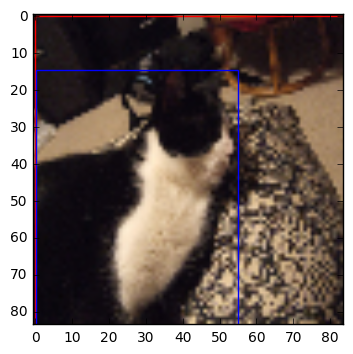

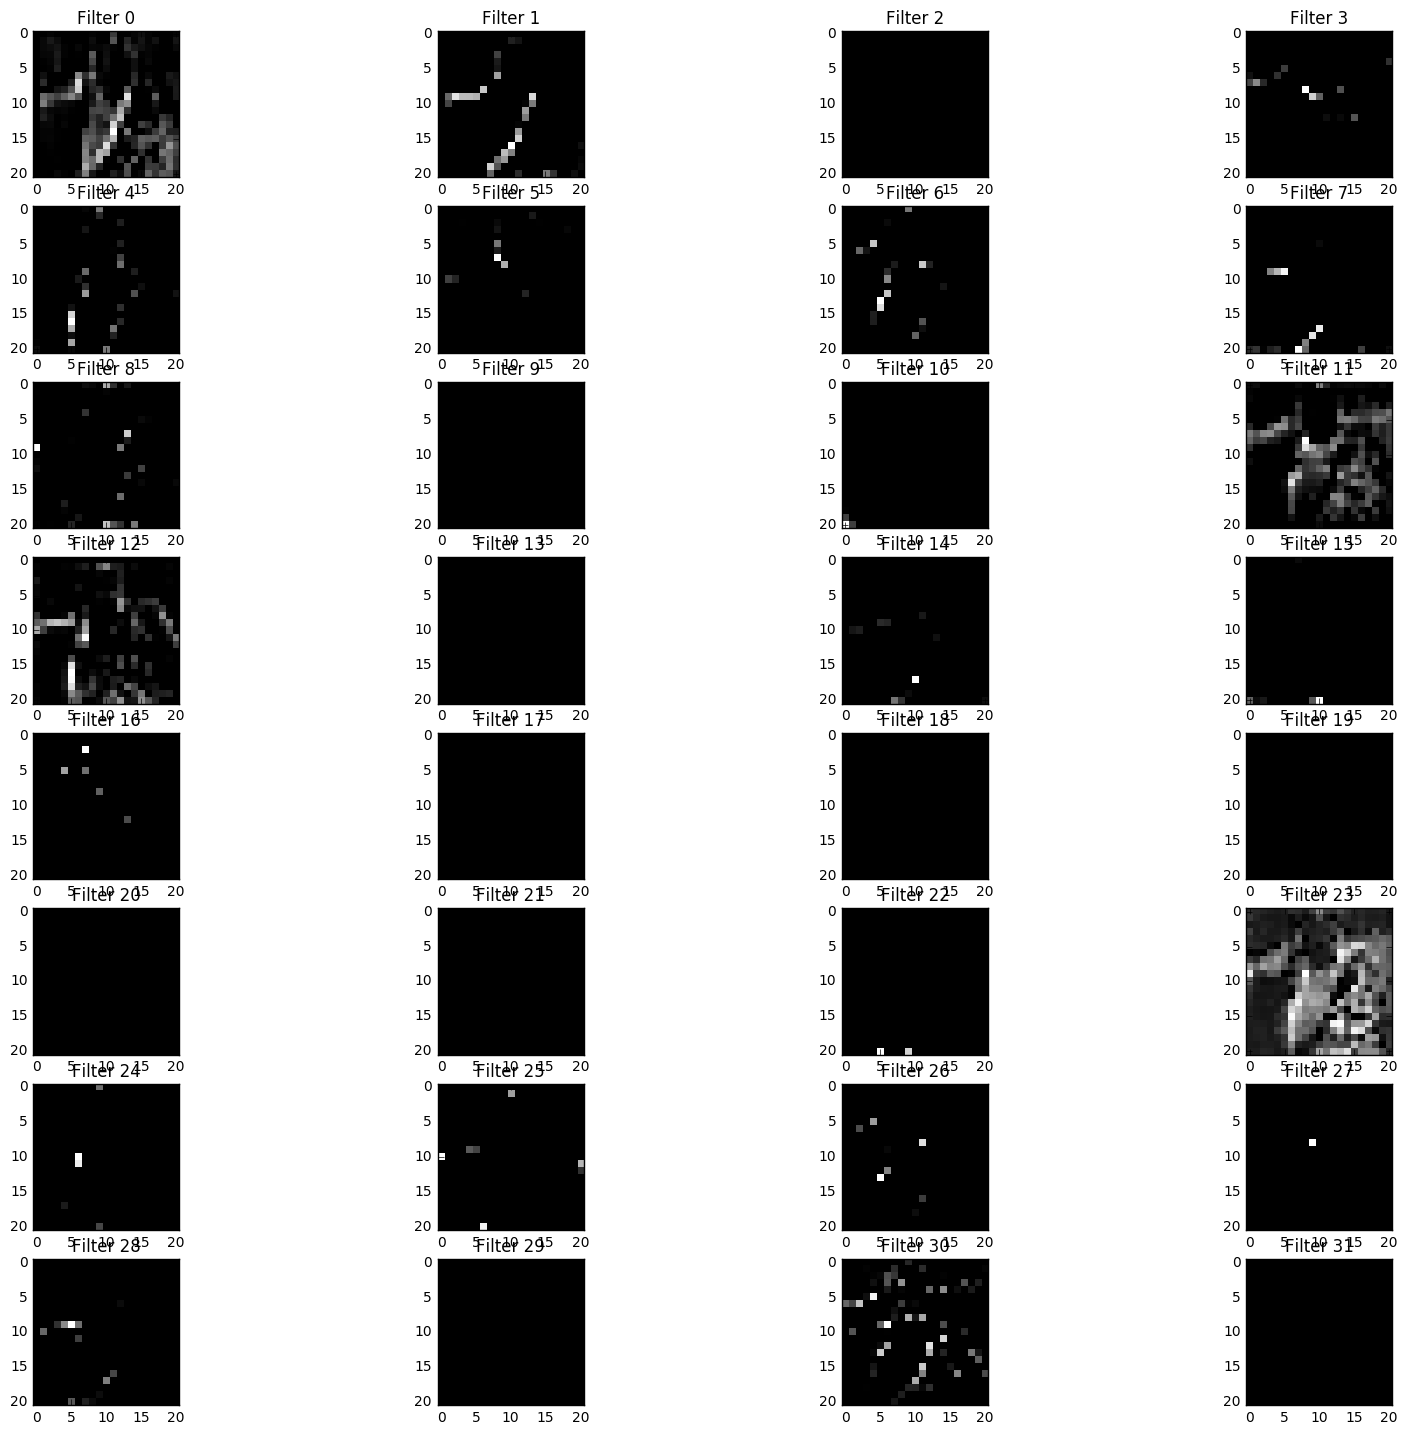

In [8]:
model_name = "cats+dog+car+chair"


tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("/home/mohammad/active localization/trained_on_cluster_final/increamental_learning/{}".format(model_name))

q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)

# State processor
state_processor = StateProcessor()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer()) # Old API: tf.initialize_all_variables()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    #report_path = os.path.join(experiment_dir, "report")

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
        
    im2 = np.array(Image.open('./input/2008_000401.jpg'))#train
    env = ObjLocaliser(np.array(im2),{'xmin':[1], 'xmax':[327], 'ymin':[65], 'ymax':[375]})
        
    env.drawActions()
    state = env.wrapping()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    q_estimator.visulize_layers(sess, state.reshape((-1, 84, 84, 4)))

    

link to code: https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Deep%20Q%20Learning%20Solution.ipynb

https://www.oreilly.com/ideas/reinforcement-learning-with-tensorflow

In [9]:
state.shape

(84, 84, 4)